# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [11]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [12]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # input channel = 1, output channels = 6, kernel size = 5
    # input image size = (32, 32), image output size = (28, 28)
    self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5)
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)

    # input channel = 6, output channels = 16, kernel size = 5
    # input image size = (14, 14), output image size = (10, 10)
    self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)

    # input dim = 5*5*16 ( H x W x C), output dim = 120
    self.fc1 = torch.nn.Linear(5*5*16, 120)
    self.active1 = torch.nn.ReLU()

    # input dim = 120, output dim = 84
    self.fc2 = torch.nn.Linear(120, 84)
    self.active2 = torch.nn.ReLU()

    # input dim = 84, output dim = 10
    self.fc3 = torch.nn.Linear(84, 10)
    self.active3 = torch.nn.LogSoftmax(dim=1)

  def forward(self, x):
    # zero padding = 2, change input image size = (32, 32)
    x = F.pad(x, (2, 2, 2, 2))

    x = self.conv1(x)
    # Max Pooling with kernel size = 2
    # output size = (14, 14)
    x = self.maxpool1(x)

    x = self.conv2(x)
    # Max Pooling with kernel size = 2
    # output size = (5, 5)
    x = self.maxpool2(x)

    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)

    x = self.fc1(x)
    x = self.active1(x)

    x = self.fc2(x)
    x = self.active2(x)

    x = self.fc3(x)
    x = self.active3(x)

    return x

### Define cost function

In [13]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [14]:
def get_optimizer(net, lr, wd, momentum):
  optimizer =  torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

### Train and test functions

In [15]:
def test(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [16]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [17]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
         device=torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50,
         net=None,
         save_path=None):

  train_loader, val_loader, test_loader = get_data(batch_size)

  # net = LeNet().to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function, device)
    val_loss, val_accuracy = test(net, val_loader, cost_function, device)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  # save model
  torch.save(net.state_dict(), save_path)

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

Lets train!

In [18]:
config = {
    "batch_size": 128,
    "device": torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
    "learning_rate": 0.01,
    "weight_decay": 0.000001,
    "momentum": 0.9,
    "epochs": 25
}

print('Training the network with the following configuration:')
print(config)

Training the network with the following configuration:
{'batch_size': 128, 'device': device(type='cuda'), 'learning_rate': 0.01, 'weight_decay': 1e-06, 'momentum': 0.9, 'epochs': 25}


In [19]:
main(**config,net=LeNet().to(config['device']),save_path='lenet.pth')

Before training:
	 Training loss 0.01807, Training accuracy 10.05
	 Validation loss 0.00908, Validation accuracy 9.72
	 Test loss 0.00922, Test accuracy 10.29
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00769, Training accuracy 67.76
	 Validation loss 0.00096, Validation accuracy 92.22
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00124, Training accuracy 95.08
	 Validation loss 0.00054, Validation accuracy 95.83
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00078, Training accuracy 96.93
	 Validation loss 0.00040, Validation accuracy 96.78
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00057, Training accuracy 97.83
	 Validation loss 0.00046, Validation accuracy 96.45
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00045, Training accuracy 98.12
	 Validation loss 0.00039, Validation accuracy 96.99
----------------

Using the proper metric from sklearn, check which character is most frequently confused with which: can you explain why ?



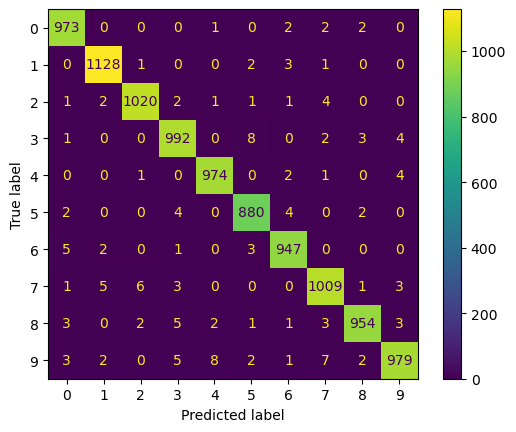

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_confusion_matrix(net, data_loader, device='cuda:0'):
    net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
    all_targets = []
    all_predicted = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            # Load data into GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = net(inputs)

            _, predicted = outputs.max(1)
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    return confusion_matrix(all_targets, all_predicted)

train_loader, val_loader, test_loader = get_data(256)
net = LeNet()
net.load_state_dict(torch.load('lenet.pth'))
cm = get_confusion_matrix(net.to(config['device']), test_loader, device=config['device'])
disp = ConfusionMatrixDisplay(cm)
disp.plot()



The LeNet5 architecture can also be implemented using the sequential API ([see documentation ](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

In [22]:
lenet = torch.nn.Sequential(
    # padding = 2, input size = 32, output size = 32
    torch.nn.ZeroPad2d(2),
    torch.nn.Conv2d(1, 6, kernel_size=5),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(6, 16, kernel_size=5),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Flatten(),
    torch.nn.Linear(5*5*16, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10),
    torch.nn.LogSoftmax(dim=1)
)

In [23]:
main(**config,net=lenet.to(config['device']),save_path='lenet_sequential.pth')

Before training:
	 Training loss 0.01806, Training accuracy 8.04
	 Validation loss 0.00907, Validation accuracy 8.13
	 Test loss 0.00922, Test accuracy 8.28
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00701, Training accuracy 72.62
	 Validation loss 0.00073, Validation accuracy 94.16
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00110, Training accuracy 95.63
	 Validation loss 0.00049, Validation accuracy 96.05
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00071, Training accuracy 97.17
	 Validation loss 0.00040, Validation accuracy 96.78
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00053, Training accuracy 97.90
	 Validation loss 0.00031, Validation accuracy 97.51
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00041, Training accuracy 98.36
	 Validation loss 0.00029, Validation accuracy 97.52
------------------

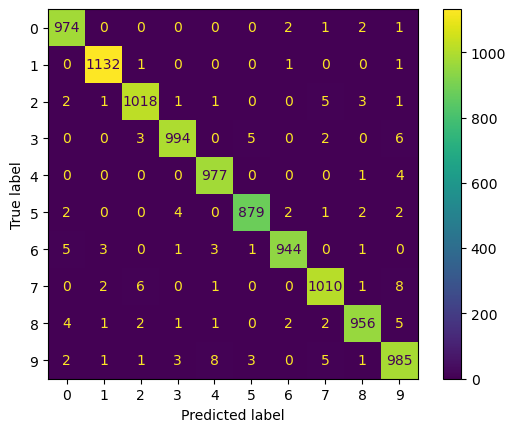

In [24]:
train_loader, val_loader, test_loader = get_data(256)
net = lenet
net.load_state_dict(torch.load('lenet_sequential.pth'))
cm = get_confusion_matrix(net.to(config['device']), test_loader, device=config['device'])
disp = ConfusionMatrixDisplay(cm)
disp.plot()

## Experiments


* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.





In [27]:
# early stopping

def main(batch_size=128,
         device=torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50,
         net=None,
         save_path=None,
         K=5):

  train_loader, val_loader, test_loader = get_data(batch_size)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  last_val_loss = 9999999.9
  last_val_acc = 0
  es = 0
  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function, device)
    val_loss, val_accuracy = test(net, val_loader, cost_function, device)

    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    # Early stopping
    if val_loss >= last_val_loss or abs(val_accuracy - last_val_acc) <= 0.01:
      print('Validation loss increased from {:.2f} to {:.2f}'.format(last_val_loss, val_loss))
      es += 1
    else:
      es = 0
    last_val_loss = val_loss
    last_val_acc = val_accuracy
    if es >= K:
      print('Early stopping at epoch {:d}'.format(e+1))
      break
    print('-----------------------------------------------------')


  # save model
  torch.save(net.state_dict(), save_path)

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [26]:
config['epochs'] = 70
net = LeNet().to(config['device'])
main(**config,net=net,save_path='lenet_early_stopping.pth',K=3)

Before training:
	 Training loss 0.01803, Training accuracy 12.46
	 Validation loss 0.00905, Validation accuracy 12.44
	 Test loss 0.00921, Test accuracy 11.89
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00750, Training accuracy 69.78
	 Validation loss 0.00076, Validation accuracy 94.09
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00119, Training accuracy 95.34
	 Validation loss 0.00045, Validation accuracy 96.56
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00076, Training accuracy 96.80
	 Validation loss 0.00043, Validation accuracy 96.56
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00060, Training accuracy 97.62
	 Validation loss 0.00034, Validation accuracy 97.36
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00045, Training accuracy 98.11
	 Validation loss 0.00030, Validation accuracy 97.71
---------------

In [28]:
# change dataset to CIFAR10

def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader



In [29]:
class LeNet_c(torch.nn.Module):
  def __init__(self):
    super(LeNet_c, self).__init__()

    # input channel = 3, output channels = 6, kernel size = 5
    # input image size = (32, 32), image output size = (28, 28)
    self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=5)
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)

    # input channel = 6, output channels = 16, kernel size = 5
    # input image size = (14, 14), output image size = (10, 10)
    self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)

    # input dim = 5*5*16 ( H x W x C), output dim = 120
    self.fc1 = torch.nn.Linear(5*5*16, 120)
    self.active1 = torch.nn.ReLU()

    # input dim = 120, output dim = 84
    self.fc2 = torch.nn.Linear(120, 84)
    self.active2 = torch.nn.ReLU()

    # input dim = 84, output dim = 10
    self.fc3 = torch.nn.Linear(84, 10)
    self.active3 = torch.nn.LogSoftmax(dim=1)

  def forward(self, x):
    # zero padding = 2, change input image size = (32, 32)
    # x = F.pad(x, (2, 2, 2, 2))

    x = self.conv1(x)
    # Max Pooling with kernel size = 2
    # output size = (14, 14)
    x = self.maxpool1(x)

    x = self.conv2(x)
    # Max Pooling with kernel size = 2
    # output size = (5, 5)
    x = self.maxpool2(x)

    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)

    x = self.fc1(x)
    x = self.active1(x)

    x = self.fc2(x)
    x = self.active2(x)

    x = self.fc3(x)
    x = self.active3(x)

    return x

In [30]:
main(**config,net=LeNet_c().to(config['device']),save_path='lenet_cifar10.pth', K=6)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Before training:
	 Training loss 0.01807, Training accuracy 10.26
	 Validation loss 0.00904, Validation accuracy 9.82
	 Test loss 0.00922, Test accuracy 9.74
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01713, Training accuracy 19.36
	 Validation loss 0.00751, Validation accuracy 31.01
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01372, Training accuracy 37.45
	 Validation loss 0.00661, Validation accuracy 39.75
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01198, Training accuracy 45.03
	 Validation loss 0.00583, Validation accuracy 46.84
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01114, Training accuracy 49.12
	 Validation loss 0.00553, Validation accuracy 49.83
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01047, Train

In [31]:
# ResNet18

class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Add a 1x1 convolution to the residual path
        if self.in_channels != self.out_channels:
            self.conv_res = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            self.bn_res = torch.nn.BatchNorm2d(out_channels)
        else:
            self.conv_res = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.conv_res:
            residual = self.conv_res(x)
            residual = self.bn_res(residual)

        out += residual
        out = self.relu(out)

        return out

class ResNet18(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(in_channels, out_channels, stride))
            in_channels = out_channels
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [32]:
main(**config,net=ResNet18(10).to(config['device']),save_path='resnet.pth',K=10)

Files already downloaded and verified
Files already downloaded and verified
Before training:


/home/infres/jkang-23/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


	 Training loss 0.01806, Training accuracy 10.77
	 Validation loss 0.00903, Validation accuracy 10.43
	 Test loss 0.00921, Test accuracy 10.54
-----------------------------------------------------


/home/infres/jkang-23/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1
	 Training loss 0.01265, Training accuracy 42.23
	 Validation loss 0.00530, Validation accuracy 51.62
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00984, Training accuracy 55.71
	 Validation loss 0.00571, Validation accuracy 51.01
Validation loss increased from 0.01 to 0.01
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00816, Training accuracy 62.94
	 Validation loss 0.00444, Validation accuracy 61.04
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00685, Training accuracy 69.38
	 Validation loss 0.00412, Validation accuracy 63.66
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00585, Training accuracy 73.62
	 Validation loss 0.00374, Validation accuracy 67.56
-----------------------------------------------------
Epoch: 6
	 Training loss 0.00490, Training accuracy 77.80
	 Validation loss 0.00397, Validation accuracy 67.53
Validation loss incr